In [1]:
#!pip3 install numpy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pprint as pprint
pp = pprint.PrettyPrinter(indent=4)
from datetime import datetime
from datetime import timedelta
import RPi.GPIO as GPIO
import time
import progressbar
import inspect, re
#import signal


%matplotlib inline  

In [12]:

#assign pin numbers
msd501pm10pin=27
msd501pm25pin=21
nova10pin=23
nova25pin=24




In [13]:
##############config system#############


def setupGPIO(pin,mode): #mode is either in or out
    GPIO.setmode(GPIO.BCM)
    if mode=="in": 
        GPIO.setup(pin, GPIO.IN)
    else:
        GPIO.setup(pin, GPIO.OUT)

        
        
###### data processing######################
def varname(p):
  for line in inspect.getframeinfo(inspect.currentframe().f_back)[3]:
    m = re.search(r'\bvarname\s*\(\s*([A-Za-z_][A-Za-z0-9_]*)\s*\)', line)
    if m:
      return m.group(1)



def checkarray(pulseinfonova): #### check the generated array
    print(pulseinfonova['pulsewidth10'])
    print(pulseinfonova['pulsewidth25'],"\n\n")
    pp.pprint(pulseinfonova)
    
#generate dataframe
def generatedf(pulseinfonova):
    df=pd.DataFrame({'time':pulseinfonova['time'],
                  'pulsewidth10':pulseinfonova['pulsewidth10'],
                  'pulsewidth25':pulseinfonova['pulsewidth25'],
                  'dust10(ng)':pulseinfonova['pulsewidth10']-2000,
                  'dust10(ug)':(pulseinfonova['pulsewidth10']-2000)/1000,
                  'dust25(ng)':pulseinfonova['pulsewidth25']-2000,
                  'dust25(ug)':(pulseinfonova['pulsewidth25']-2000)/1000,  
                  "time(s)":pulseinfonova['second']/1000,
                  "readtime(s)":pulseinfonova['readtime'],
                   "pulsetime10":pulseinfonova["pulsetime10"],
                    "pulsetime25":pulseinfonova["pulsetime25"]})
    #add info
    df["dust10(ppm)"]=df['dust10(ug)']*1.225
    df["dust25(ppm)"]=df['dust25(ug)']*1.225
    df["rolling mean 10(ppm)"] = df["dust10(ppm)"].rolling(10,center=True).mean()
    df["rolling mean 25(ppm)"] = df["dust25(ppm)"].rolling(10,center=True).mean()
    df.fillna(method='bfill',inplace=True)
    df["error10"]= np.power(np.power(df["rolling mean 10(ppm)"]-df["dust10(ppm)"],2),0.4)
    df["error25"]= np.power(np.power(df["rolling mean 25(ppm)"]-df["dust25(ppm)"],2),0.4)
    #fill in na just in case
    df.fillna(method='bfill',inplace=True)
    df.fillna(method='ffill',inplace=True)
    return df


############ reading the pins#######        


def readpulse(pin):   ###read high pulse width
    for i in range(2):
        start = datetime.now()
        stop = datetime.now()
        while GPIO.input(pin) == 0:
            continue
        start = datetime.now()
        while GPIO.input(pin) == 1:
            continue
        stop = datetime.now()
        Elapsed = stop - start
    return Elapsed.total_seconds()*1000000


def readpulsewidth(pin10,pin25,number_of_readings): ###read high pulse width (2 at the same time)
    pulsewidth10=np.array([])
    pulsewidth25=np.array([])
    time=[]
    second=np.array([])
    start_time=datetime.now()
    with progressbar.ProgressBar(max_value=number_of_readings) as bar:
        while True:
            pulsereading10=readpulse(pin10)
            pulsereading25=readpulse(pin25)
            if pulsereading10 > 1000 and pulsereading25 > 1000:
                pulsewidth10=np.append(pulsewidth10,pulsereading10)
                pulsewidth25=np.append(pulsewidth25,pulsereading25)
                time.append(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
                second=np.append(second,(datetime.now()-start_time)*1000)
            if pulsewidth10.size>= number_of_readings:
                break
            bar.update(pulsewidth10.size)
            #print("currently at loop",pulsewidth10.size)
    return {"pulsewidth10":pulsewidth10,"pulsewidth25":pulsewidth25,"time":time,"second":second}


def read_pulsewidth_and_pulse_time(number_of_readings,pin10=None,pin25=None,pinmsd10=None,pinmsd25=None): ###read high pulse width (2 at the same time)
    pulsewidth10=np.array([])
    pulsewidth25=np.array([])
    pulsetime10=np.array([])
    pulsetime25=np.array([])
    time=[]
    second=np.array([])
    start_time=datetime.now()
    readtime_per_channel=np.array([])
    with progressbar.ProgressBar(max_value=number_of_readings) as bar:
        while True:
            startreadtime=datetime.now()
            pulsereading10=readpulse(pin10)
            pulsereading25=readpulse(pin25)
            if pulsereading10 > 1000 and pulsereading25 > 1000:
                pulsewidth10=np.append(pulsewidth10,pulsereading10)
                pulsewidth25=np.append(pulsewidth25,pulsereading25)
                time_for_pulseread=(datetime.now()-startreadtime).total_seconds()*0.25
                readtime_per_channel=np.append(readtime_per_channel,time_for_pulseread)
                time.append(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
                second=np.append(second,(datetime.now()-start_time).total_seconds()*1000)
                if pinmsd10:
                    pulsetime10=np.append(pulsetime10,check_low_pulse_for(pinmsd10,time_for_pulseread)["ratio"])                   
                if pinmsd25:
                    pulsetime25=np.append(pulsetime25,check_low_pulse_for(pinmsd25,time_for_pulseread)["ratio"])
            if pulsewidth10.size>= number_of_readings:
                break
            bar.update(pulsewidth10.size)
            #print("currently at loop",pulsewidth10.size)
    return {"pulsewidth10":pulsewidth10,"pulsewidth25":pulsewidth25,"time":time,"second":second,"pulsetime10":pulsetime10,"pulsetime25":pulsetime25,"readtime":readtime_per_channel}



def readpulselow(pin): ## read low pulse width
    for i in range(1):
        start = datetime.now()
        stop = datetime.now()
        while GPIO.input(pin) == 1:
            continue
        start = datetime.now()
        while GPIO.input(pin) == 0:
            continue
        stop = datetime.now()
        Elapsed = stop - start
    return Elapsed.total_seconds()*1000



def check_low_pulse_for(pin,period):#period in seconds #check low ratio in active low circuits over a period #return dict
    start=datetime.now()
    #signal.alarm(period)
    activeperiod=0
    while (datetime.now()-start).total_seconds()<period:
        activeperiod+=readpulselow(pin)
    
    totalperiod=(datetime.now()-start).total_seconds()*1000
    #print ("Timeout! at {time_elasped}".format(time_elasped=(datetime.now()-start).total_seconds()))
    return {'lowpulse':activeperiod,'total_period':totalperiod,'ratio':activeperiod/totalperiod}
    

    
def readlowsensorasdf(pin,size,period):###output dataframe from readings with specified repitition and period return df
    readings=[]
    output_dict={}
    for i in range(size):
        readings.append(check_low_pulse_for(msd501pm10pin,period))
    for i in readings[0].keys():
        output_dict[i]=[]
    for i in readings:
        for j in i.keys():
            output_dict[j].append(i[j])
    return pd.DataFrame(output_dict)    
    

####### debug functions#####


def infinite_loop():
    start=datetime.now()
    try:
        while True:
            print('the time is {time}'.format(time=(start-datetime.now()).total_seconds()))
            time.sleep(1)
    
    except Exception:
        print ("Timeout! at {time_elasped}".format(time_elasped=(datetime.now()-start).total_seconds()))
        
        
def testpulse(pin,periods):
    #end_time = datetime.now() + timedelta(seconds=20)
    count=0
    while count<periods:
        #time.sleep(1)
        #print(GPIO.input(23))
        dustlevel= float(readpulse(pin)+1-1)-2
        print("the dust level is :", dustlevel)
        count+=1

def testlowpulse(pin,times=5):
    for i in times:
        Lowpulse = readpulselow(pin)
        print(Lowpulse)

In [14]:
#set up gpio
pin_input=[msd501pm10pin, msd501pm25pin, nova10pin,nova25pin]
pin_name=['msd501pm10pin', 'msd501pm25pin', 'nova10pin','nova25pin']
for pin in pin_input:
    setupGPIO(pin,"in")

In [19]:
#run test for output
for pin,name in zip(pin_input,pin_name):
    print(name)
    testpulse(pin,3)

msd501pm10pin
the dust level is : 5012.0
the dust level is : 5064.0
the dust level is : 5057.0
msd501pm25pin
the dust level is : 5816.0
the dust level is : 5951.0
the dust level is : 5950.0
nova10pin
the dust level is : 3984.0
the dust level is : 3990.0
the dust level is : 3993.0000000000005
nova25pin
the dust level is : 3986.0
the dust level is : 3986.0
the dust level is : 3992.0


In [ ]:
def testnova(nova10pin,nova25pin,times):
    for i in [nova10pin,nova25pin]:
        testpulse(i,times)
testnova(nova10pin,nova25pin,3)


In [25]:
testpulse(27,100)

the dust level is : 5320.0
the dust level is : 5318.0
the dust level is : 5460.0
the dust level is : 5328.0
the dust level is : 5435.0
the dust level is : 5279.0
the dust level is : 5428.0
the dust level is : 5233.0
the dust level is : 5390.0
the dust level is : 5168.0
the dust level is : 5320.0
the dust level is : 5197.0
the dust level is : 5284.0
the dust level is : 5230.0
the dust level is : 5341.0
the dust level is : 5266.0
the dust level is : 5389.0
the dust level is : 5257.0
the dust level is : 5481.0
the dust level is : 5300.0
the dust level is : 5483.0
the dust level is : 5288.0
the dust level is : 5509.0
the dust level is : 5299.0
the dust level is : 5443.0
the dust level is : 5202.0
the dust level is : 5369.0
the dust level is : 5201.0
the dust level is : 5305.0
the dust level is : 5233.0
the dust level is : 5337.0
the dust level is : 5249.0
the dust level is : 5452.0
the dust level is : 5342.0
the dust level is : 5489.0
the dust level is : 5368.0
the dust level is : 5460.0
t

In [ ]:
#set data variables
datasize=10

#call data
#pulseinfonova=readpulsewidth(nova10pin,nova25pin,datasize)
pulseinfonova=read_pulsewidth_and_pulse_time(datasize,nova10pin,nova25pin,msd501pm10pin,msd501pm25pin)
checkarray(pulseinfonova)


In [ ]:
df=generatedf(pulseinfonova)
df.head(5)

In [ ]:
#save file
filename="./data/test{time}_{samples}samples.csv".format(time=datetime.now().strftime("%d%b%y_%H:%M"),samples=datasize)
df.to_csv(filename)

In [ ]:
#load file
filename='./data/test05Feb19_04:29_5samples.csv'
df=pd.read_csv(filename)

In [ ]:
df.head()

In [ ]:
def plotchart(df):
    #create charts to show the distribution of the readings
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15, 10))
    sns.set(style="darkgrid")
    #Plot against dust (line)
    sns.relplot(x="time(s)", y="dust10(ppm)",kind="line",data=df,ax=ax1)
    sns.relplot(x="time(s)", y="rolling mean 10(ppm)",kind="line",color="coral",data=df,ax=ax1)
    sns.lineplot(x="time(s)", y="rolling mean 10(ppm)",color="coral",data=df,ax=ax2)
    ax2.errorbar(df["time(s)"],y=df["rolling mean 10(ppm)"],yerr=df["error10"],color="c")
    ax1.set_title("moving average vs raw data")
    return[ax1,ax2]

In [ ]:
ax1,ax2=plotchart(df)
#ax1.lines[0].get_linewidth()
plt.setp(ax1.lines[0],linewidth=1)
plt.setp(ax1.lines[1],linewidth=5)
plt.setp(ax2.lines[0],linewidth=5)
plt.setp(ax2.lines[1],linewidth=1)
ax1.legend(handles=ax1.lines, labels=["pm10_rawdata","pm10_average"],loc='upper right')
ax2.legend(handles=ax2.lines, labels=["pm10_average","error_bar"],loc='upper right')

In [ ]:
f, axes = plt.subplots(1, 2,figsize=(13, 5))
sns.set_context("poster")
sns.distplot(df["dust10(ug)"],ax=axes[0])
sns.distplot(df["dust25(ug)"],ax=axes[1])

# READ dm501

In [ ]:
msd501pm10_reading=check_low_pulse_for(msd501pm10pin,2)
print(msd501pm10_reading)

In [ ]:
pprint.pprint(readings)  

In [ ]:

readings_df=readlowsensorasdf(msd501pm10pin,10000,0.1)
readings_df.describe()

In [85]:
readings_df.to_csv("./data/readings_df{datetime}.csv".format(datetime=datetime.now().strftime("%d%b%y_%H:%M")))

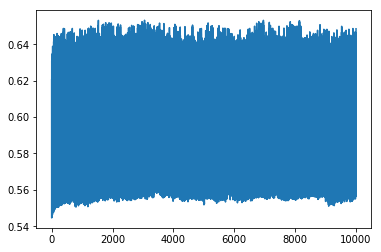

In [83]:
ax=plt.plot(readings_df['ratio'])

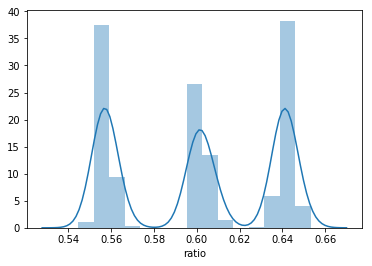

In [86]:
sns.distplot(readings_df['ratio']);

In [123]:
def read_pulsewidth_and_pulse_time(number_of_readings,pin10=None,pin25=None,pinmsd10=None,pinmsd25=None): ###read high pulse width (2 at the same time)
    pulsewidth10=np.array([])
    pulsewidth25=np.array([])
    pulsetime10=np.array([])
    pulsetime25=np.array([])
    time=[]
    second=np.array([])
    start_time=datetime.now()
    with progressbar.ProgressBar(max_value=number_of_readings) as bar:
        while True:
            startreadtime=datetime.now()
            pulsereading10=readpulse(pin10)
            pulsereading25=readpulse(pin25)
            if pulsereading10 > 1 and pulsereading25 > 1:
                pulsewidth10=np.append(pulsewidth10,pulsereading10)
                pulsewidth25=np.append(pulsewidth25,pulsereading25)
                time_for_pulseread=(datetime.now()-startreadtime).total_seconds()*0.5
                time.append(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
                second=np.append(second,(datetime.now()-start_time).total_seconds()*1000)
                if pinmsd10:
                    pulsetime10=np.append(pulsetime10,check_low_pulse_for(pinmsd10,time_for_pulseread)["ratio"])                   
                if pinmsd25:
                    pulsetime25=np.append(pulsetime25,check_low_pulse_for(pinmsd25,time_for_pulseread)["ratio"])
            if pulsewidth10.size>= number_of_readings:
                break
            bar.update(pulsewidth10.size)
            #print("currently at loop",pulsewidth10.size)
    return {"pulsewidth10":pulsewidth10,"pulsewidth25":pulsewidth25,"time":time,"second":second,"pulsetime10":pulsetime10,"pulsetime25":pulsetime25}

In [124]:
read_pulsewidth_and_pulse_time(5,nova10pin,nova25pin,msd501pm10pin,msd501pm25pin)


pin10 is read 27.985
pin25 is read 30.979
1.0368665
pulse10 is read


N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

pulse25 is read
pin10 is read 27.976
pin25 is read 30.973
1.457234
pulse10 is read


 40% (2 of 5) |##########                | Elapsed Time: 0:00:05 ETA:   0:00:08

pulse25 is read
pin10 is read 27.979
pin25 is read 30.979
1.037069
pulse10 is read


 60% (3 of 5) |###############           | Elapsed Time: 0:00:10 ETA:   0:00:08

pulse25 is read
pin10 is read 27.982
pin25 is read 30.98
1.468241
pulse10 is read


 80% (4 of 5) |####################      | Elapsed Time: 0:00:15 ETA:   0:00:05

pulse25 is read
pin10 is read 27.976999999999997
pin25 is read 30.979
1.0272225
pulse10 is read


100% (5 of 5) |##########################| Elapsed Time: 0:00:20 Time:  0:00:20


pulse25 is read


{'pulsetime10': array([0.58634406, 0.59170871, 0.59095303, 0.59372239, 0.59400292]),
 'pulsetime25': array([0.55996166, 0.55496657, 0.55676298, 0.55742841, 0.55734262]),
 'pulsewidth10': array([27.985, 27.976, 27.979, 27.982, 27.977]),
 'pulsewidth25': array([30.979, 30.973, 30.979, 30.98 , 30.979]),
 'second': array([ 2074.719,  7091.951, 12109.061, 17126.548, 22143.94 ]),
 'time': ['2019-02-02 14:00:41',
  '2019-02-02 14:00:46',
  '2019-02-02 14:00:51',
  '2019-02-02 14:00:56',
  '2019-02-02 14:01:01']}